In [ ]:
from collections import OrderedDict
import copy
from google.colab import drive
from IPython.display import display
import matplotlib
matplotlib.rcParams['figure.figsize'] = [4, 3]
matplotlib.rcParams['font.size'] = 8
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch import log, manual_seed, nn, ones_like, optim, pow, tensor
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# CMAP Dataset

## Data import

In [ ]:
size = 10000
var, alt = 'auto_cost', 0
data1 = pd.read_csv('/content/drive/My Drive/CMAP/data.csv', index_col=0).sample(size, random_state=0)
data1['mode_imputed'] = data1['mode_imputed'].add(-1)

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode_imputed'] = data1['mode_imputed']

In [ ]:
train_size = int(size*.7)
data_train, data_test = data[:train_size], data[train_size:]

## Data processing
2. Build a dataframe with mean values, except for the visualized variable,
3. Build a dataframe with the same size for model regularity calculation, and
4. Load the data for training and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
data_prb = pd.DataFrame(np.zeros((51, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, len(data_prb))

In [ ]:
data_reg = data_test.copy()
data_reg = data_reg.loc[data_reg.index.repeat(2)]
num_var = data_reg.columns.get_loc(var)
data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 50

In [ ]:
class Load_data(Dataset):
    'Class to load the training, testing, and plotting sets'
    def __init__(self, data):
        x_set = data.drop(columns='mode_imputed')
        y_set = data['mode_imputed']
        self.X = Variable(tensor(x_set.values).float(), requires_grad=True)
        self.y = tensor(y_set.values)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

train_loader = DataLoader(Load_data(data_train), batch_size=size//10, shuffle=True)
test_loader = DataLoader(Load_data(data_test), batch_size=len(data_test))

# Datasets for model analysis
share_loader = DataLoader(Load_data(data_train), batch_size=train_size)
prb_loader = DataLoader(Load_data(data_prb), batch_size=len(data_prb))
reg_loader = DataLoader(Load_data(data_reg), batch_size=len(data_reg))

## True market shares

In [ ]:
ls_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode_imputed'].replace(0, ls_alt[0]).replace(1, ls_alt[1]).replace(2, ls_alt[2])
    return y.value_counts(normalize=True)

In [ ]:
# Training set
true_share(data_train)

Auto      0.699571
Active    0.202429
Train     0.098000
Name: mode_imputed, dtype: float64

In [ ]:
# Testing set
true_share(data_test)

Auto      0.703667
Active    0.191333
Train     0.105000
Name: mode_imputed, dtype: float64

# Multinomial Logit (MNL)

## Data processing
The MNL model is estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:4]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode_imputed', 'alt_id')
    return df_lg

In [ ]:
data1_train, data1_test = data1[:train_size], data1[train_size:]
data1_train_lg = convert(data1_train)
data1_train_lg

,obs_id,alt_id,mode_imputed,sex,inc,age,veh,time,cost
0,1,0,0,1,0,40,0,9.216667,6.5078
1,1,1,1,1,0,40,0,32.450000,2.2750
2,1,2,0,1,0,40,0,30.500000,0.0000
3,2,0,1,0,1,55,1,5.883333,7.0628
4,2,1,0,0,1,55,1,37.116667,2.0800
...,...,...,...,...,...,...,...,...,...
20995,6999,1,0,1,1,38,2,56.550000,2.5100
20996,6999,2,0,1,1,38,2,35.266667,0.0000
20997,7000,0,1,1,0,39,1,4.883333,7.0898
20998,7000,1,0,1,0,39,1,20.316667,2.4250


## Model structure
The observed utilities are specified as follows:

\begin{align}
V_c &= w_{\mathrm{time},c} \mathrm{time}_c + w_{\mathrm{cost},c} \mathrm{cost}_c \\
V_t &= w_{0,t} + w_{\mathrm{sex},t} \mathrm{sex} + w_{\mathrm{inc},t} \mathrm{inc} + w_{\mathrm{age},t} \mathrm{age} + w_{\mathrm{veh},t} \mathrm{veh} + w_{\mathrm{time},t} \mathrm{time}_t + w_{\mathrm{cost},t} \mathrm{cost}_t \\
V_a &= w_{0,a} + w_{\mathrm{sex},a} \mathrm{sex} + w_{\mathrm{inc},a} \mathrm{inc} + w_{\mathrm{age},a} \mathrm{age} + w_{\mathrm{veh},a} \mathrm{veh} + w_{\mathrm{time},a} \mathrm{time}_a
\end{align}

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['sex'] = [1, 2]
name['sex'] = ['sex_train', 'sex_active']
spec['inc'] = [1, 2]
name['inc'] = ['inc_train', 'inc_active']
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['veh'] = [1, 2]
name['veh'] = ['veh_train', 'veh_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

## Parameter estimation

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode_imputed',
                             specification=spec, model_type='MNL', names=name)
mnl.fit_mle(np.zeros(15))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860
Estimation Time for Point Estimation: 0.13 seconds.
Final log-likelihood: -4,836.7211


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                mode_imputed   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,985
Method:                                MLE   Df Model:                           15
Date:                     Tue, 11 Jul 2023   Pseudo R-squ.:                   0.371
Time:                             12:03:03   Pseudo R-bar-squ.:               0.369
AIC:                             9,703.442   Log-Likelihood:             -4,836.721
BIC:                             9,806.247   LL-Null:                    -7,690.286
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
asc_train      -2.6105      0.318     -8.202      0.000      -3.234      -1.987
asc_active     -0.9922      0.160     -6.219      0.000      -1.305      -0.680
sex_train       0.4491      0.087      5.175      0.000       0.279       0.619
sex_active      0.4371      0.066      6.655      0.000       0.308       0.566
inc_train       0.5552      0.098      5.694      0.000       0.364       0.746
inc_active      0.5609      0.073      7.692      0.000       0.418       0.704
age_train      -0.0092      0.003     -2.659      0.008      -0.016      -0.002
age_active     -0.0105      0.003     -4.020      0.000      -0.016      -0.005
veh_train      -0.6272      0.057    -11.094      0.000      -0.738      -0.516
veh_active     -0.8604      0.044    -19.526      0.000      -0.947      -0.774
time_auto      -0.0624      0.007     -8.861      0.000      -0.076      -0.049
time_train     -0.0364      0.003    -13.806      0.000      -0.042      -0.031
time_active    -0.0265      0.001    -18.561      0.000      -0.029      -0.024
cost_auto      -0.1586      0.020     -7.824      0.000      -0.198      -0.119
cost_train      0.2344      0.135      1.731      0.084      -0.031       0.500
===============================================================================
"""

## Results

In [ ]:
def mnl_share(df):
    'Function to calculate the MNL market shares'
    pop = len(df)//3
    X = df.drop(columns='mode_imputed')
    prb = sum(mnl.predict(X).reshape(pop, 3)) / pop
    share = pd.DataFrame(prb*100, columns=['Share']).round(decimals=1).astype(str).add('%')
    share.insert(0, 'Mode', ls_alt)
    return share

In [ ]:
# Training set
mnl_share(data1_train_lg)

,Mode,Share
0,Auto,70.0%
1,Train,9.8%
2,Active,20.2%


In [ ]:
# Testing set
data1_test_lg = convert(data1_test)
mnl_share(data1_test_lg)

,Mode,Share
0,Auto,69.4%
1,Train,10.1%
2,Active,20.5%


In [ ]:
prb = mnl.predict(data1_test_lg).reshape(len(data1_test_lg)//3, 3)
y_test = data_test['mode_imputed']
acc = (prb.argmax(1) == y_test).sum() / len(y_test)
print(f'Test accuracy = {acc*100:.1f}%')

Test accuracy = 72.0%


In [ ]:
ll = 0
for i in range(len(data1_test_lg)//3):
    ll += np.log(prb[i, y_test.iloc[i]])
print(f'Test log-likelihood = {ll:.1f}')

Test log-likelihood = -2058.4


In [ ]:
# Plot the histogram of test accuracies
# plt.hist(acc, bins=25, range=(.4, .9), color='mediumblue')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
# plt.xlabel('Test accuracy')
# plt.ylabel('Percentage of all trials')
# plt.show()

In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (51, 1)), columns=data1.columns)
data1_prb['mode_imputed'] = pd.Series([np.random.randint(0, 3) for i in range(len(data1_prb))])
data1_prb[var] = np.linspace(lower1, upper1, len(data1_prb))

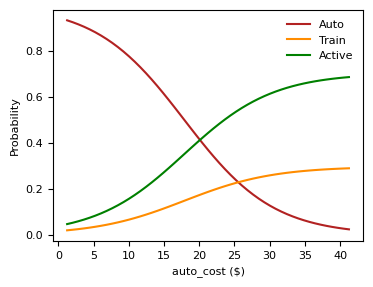

In [ ]:
data1_prb_lg = convert(data1_prb)
ls1_prb = mnl.predict(data1_prb_lg).reshape(len(data1_prb_lg)//3, 3)
ls1_grd = mnl.params[11] * ls1_prb[:, alt] * (1-ls1_prb[:, alt])

# Plot probabilities
# plt.plot(data1_prb[var], ls1_prb[:, alt], color='dimgrey')
# plt.xlabel(f'{var}')
# plt.ylabel('Probability')
# plt.show()

# Plot probability derivatives
# plt.plot(data1_prb[var], ls1_grd, color='dimgrey')
# plt.xlabel(f'{var}')
# plt.ylabel('Probability derivative')
# plt.show()

# Plot substitution patterns
ls_color = ['firebrick', 'darkorange', 'green', 'mediumblue']
# plt.axvline(data1.iloc[train_size, num_var], ls='--', color='darkgray')
for a in range(3):
    plt.plot(data1_prb[var], ls1_prb[:, a], color=ls_color[a], label=ls_alt[a])
plt.legend(frameon=False)
plt.xlabel(f'{var} ($)')
plt.ylabel('Probability')
plt.show()

In [ ]:
data1_reg = data1_test.copy()
data1_reg = data1_reg.loc[data1_reg.index.repeat(2)]
data1_reg.iloc[np.arange(1, len(data1_reg), 2), num_var] += (upper1 - lower1) / 50

data1_reg_lg = convert(data1_reg)
ls1_reg = mnl.predict(data1_reg_lg).reshape(len(data1_reg_lg)//3, 3)[:, alt]

In [ ]:
def cal_reg(ls_reg):
    eps = 1e-4
    diff = np.subtract(ls_reg[::2], ls_reg[1::2])
    diff_st = [(d > eps).astype(int) for d in diff]
    diff_wk = [(d > -eps).astype(int) for d in diff]
    reg_st = sum(diff_st) / len(diff_st)
    reg_wk = sum(diff_wk) / len(diff_wk)
    print(f'Strong regularity = {reg_st:.4f}')
    print(f'Weak regularity = {reg_wk:.4f}')
    return reg_st, reg_wk

In [1]:
# reg_st, reg_wk = cal_reg(ls1_reg)

# Deep neural network (DNN)

## Model structure

In [ ]:
class DNN(nn.Module):
    'Class of DNNs'
    def __init__(self):
        super(DNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

## Model training
We train each model 30 times and take the average results of 10 models for analysis.

In [ ]:
def cal_loss(model, X, y, regularizer, sum, lambd, criterion):
    'Function to regularize the loss function'
    'lambd is the weight of regularizer -> (1-lambd) is the weight of loss'
    'sum is an indicator of regularizing summation'
    loss = criterion(model(X), y)
    # Utility gradient regularizer
    if regularizer == 'util':
        utl = model(X)
        g_c = grad(utl[:, 0], X, ones_like(utl[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(utl[:, 1], X, ones_like(utl[:, 1]), create_graph=True)[0][:, 6:8]
        g_a = grad(utl[:, 2], X, ones_like(utl[:, 2]), create_graph=True)[0][:, 8]
    # Probability gradient regularizer
    elif regularizer == 'prob':
        prb = softmax(model(X), dim=1)
        g_c = grad(prb[:, 0], X, ones_like(prb[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(prb[:, 1], X, ones_like(prb[:, 1]), create_graph=True)[0][:, 6:8]
        g_a = grad(prb[:, 2], X, ones_like(prb[:, 2]), create_graph=True)[0][:, 8]
    # Loss gradient regularizer
    elif regularizer == 'loss':
        log_prb = log(softmax(model(X), dim=1))
        g_c = grad(log_prb[:, 0]*(y==0), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 4:6]
        g_t = grad(log_prb[:, 1]*(y==1), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 6:8]
        g_a = grad(log_prb[:, 2]*(y==2), X, ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8]
    else:
        return loss
    # Compute the regularizer
    if sum:
        g_c[g_c < 0] = 0
        g_t[g_t < 0] = 0
        g_a[g_a < 0] = 0
        reg = g_c.sum() + g_t.sum() + g_a.sum()
    else:
        reg = pow(g_c, 2).sum() + pow(g_t, 2).sum() + pow(g_a, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, regularizer, sum, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for batch, (X, y) in enumerate(train_loader):
        loss = cal_loss(model, X, y, regularizer, sum, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, criterion):
    'Function for DNN testing'
    # For loss, accuracy, and market share (testing set) calculation
    for X, y in test_loader:
        pred = model(X)
        loss = criterion(pred, y).item()
        cor = (pred.argmax(1) == y).float().sum()
        share_test = softmax(pred, dim=1).detach().numpy()
        p = softmax(pred, dim=1)
    loss /= len(test_loader)
    acc = cor / len(test_loader.dataset)
    # For market share (training set) calculation
    for X, _ in share_loader:
        share_train = softmax(model(X), dim=1).detach().numpy()
    # For probability and gradient calculation
    for X, _ in prb_loader:
        p = softmax(model(X), dim=1)
        prb = p.detach().numpy()
        grd = grad(p[:, alt], X, ones_like(p[:, alt]), create_graph=True)[0][:, num_var].detach().numpy()
    # For regularity calculation
    for X, _ in reg_loader:
        reg = softmax(model(X), dim=1)[:, alt].detach().numpy()
    return loss, acc, share_train, share_test, prb, grd, reg

In [ ]:
def train_DNN(regularizer, sum, lambd):
    'Function for DNN training (10 models * 30 epochs)'
    ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb, ls_grd, ls_reg = [[] for i in range(7)]
    for m in range(10):
        manual_seed(m)
        model = DNN()
        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        for i in range(30):
            train_loop(model, regularizer, sum, lambd, optimizer, criterion)
        loss, acc, share_train, share_test, prb, grd, reg = test(model, criterion)
        [x.append(y) for x, y in zip([ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb,
                                      ls_grd], [loss, acc, share_train, share_test, prb, grd])]
        ls_reg.extend(reg)
        print(f'Model {m+1:<2}: {loss:.4f}, {acc*100:.1f}%')
    return ls_loss, ls_acc, ls_share_tr, ls_share_ts, np.array(ls_prb), ls_grd, ls_reg

## Functions for analysis
We evaluate the models by:
- test losses and accuracies,
- strong and weak regularities.

In [ ]:
def dnn_agg(ls_loss, ls_acc):
    'Function to analyze aggregate DNN performance'
    mean_loss, mean_acc = np.mean(ls_loss), np.mean(ls_acc)
    ll = -mean_loss * (size - train_size)
    print(f'Mean test log-likelihood = {ll:.1f}')
    print(f'Mean test accuracy = {mean_acc*100:.1f}%')
    agg_ll, agg_acc = ll, mean_acc
    # Plot the histogram of test accuracies
    # plt.hist(ls_acc, bins=25, range=(.4, .9), weights=np.ones(len(ls_acc))/len(ls_acc), color='mediumblue')
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
    # plt.xlabel('Test accuracy')
    # plt.ylabel('Percentage of all trials')
    # plt.show()
    return agg_ll, agg_acc

In [ ]:
def dnn_share(ls_share):
    'Function to analyze DNN market shares of modes'
    share = [sum(s)/len(s) for s in ls_share]
    avg_share = np.mean(share, 0) * 100
    std_share = np.std(share, 0) * 100
    df_avg = pd.DataFrame(avg_share).round(decimals=1)
    df_std = pd.DataFrame(std_share).round(decimals=1)
    df = df_avg.astype(str).add('% (').add(df_std.astype(str)).add('%)')
    df.columns = ['Share']
    df.insert(0, 'Mode', ls_alt)
    display(df)

In [ ]:
def dnn_sub(ls_prb, ls_grd):
    'Function to analyze DNN probabilities, probability derivatives, and substitution patterns'
    # Plot probabilities
    # for p in ls_prb[:, :, alt]:
    #     plt.plot(data1_prb[var], p, color='dimgrey', alpha=.15)
    # plt.plot(data1_prb[var], np.mean(ls_prb[:, :, alt], axis=0), color='dimgrey')
    # plt.xlabel(f'{var}')
    # plt.ylabel('Probability')
    # plt.show()
    # Plot probability derivatives
    # for p in ls_grd:
    #     plt.plot(data1_prb[var], p, color='dimgrey', alpha=.15)
    # plt.plot(data1_prb[var], np.mean(ls_grd, axis=0), color='dimgrey')
    # plt.xlabel(f'{var}')
    # plt.ylabel('Probability derivative')
    # plt.show()
    # Plot substitution patterns
    # plt.axvline(data1.iloc[train_size, num_var], ls='--', color='darkgray')
    for a in range(3):
        for p in ls_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=ls_color[a], alpha=.15)
        plt.plot(data1_prb[var], np.mean(ls_prb[:, :, a], axis=0), color=ls_color[a], label=ls_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    plt.show()

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, ls_st, ls_wk):
    'Function to compare DNN models'
    if len(lambdas) == 1:
        return
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()
    # Plot test log-likelihoods
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='x', color=ls_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood')
    # Plot test accuracies
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='x', color=ls_color[1], label='Accuracy')
    ax2.set_ylabel('Test accuracy & Regularity')
    # Plot regularities
    ax2.plot(np.log10(lambdas), ls_st, linestyle='dashed', marker='x', color=ls_color[2], label='Strong regularity')
    ax2.plot(np.log10(lambdas), ls_wk, linestyle='dashed', marker='x', color=ls_color[3], label='Weak regularity')
    # fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes, frameon=False)

In [ ]:
def result(regularizer, lambdas=[0], sum=True):
    'Function to display all DNN results'
    agg_loss, agg_acc, ls_st, ls_wk = [[] for i in range(4)]
    for lambd in lambdas:
        print('Penalty =', lambd)
        # Individual losses and accuracies
        print('-'*30, '\nTest losses and accuracies:')
        ls_loss, ls_acc, ls_share_tr, ls_share_ts, ls_prb, ls_grd, ls_reg = train_DNN(regularizer, sum, lambd)
        # Mean loss and accuracy
        print('-'*30)
        [x.append(y) for x, y in zip([agg_loss, agg_acc], dnn_agg(ls_loss, ls_acc))]
        # Market shares
        print('-'*30, '\nTraining set:')
        dnn_share(ls_share_tr)
        print('-'*30, '\nTesting set:')
        dnn_share(ls_share_ts)
        # Regularities
        print('-'*30)
        reg_st, reg_wk = cal_reg(ls_reg)
        # Substitution patterns
        print('-'*30)
        dnn_sub(ls_prb, ls_grd)
        [x.append(y) for x, y in zip([ls_st, ls_wk], [reg_st, reg_wk])]
    comparison(lambdas, agg_loss, agg_acc, ls_st, ls_wk)

## Results

### Without regularization

Penalty = 0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6317, 73.1%
Model 2 : 0.6330, 73.4%
Model 3 : 0.6392, 72.9%
Model 4 : 0.6378, 72.9%
Model 5 : 0.6335, 73.2%
Model 6 : 0.6336, 73.1%
Model 7 : 0.6375, 72.5%
Model 8 : 0.6342, 72.7%
Model 9 : 0.6348, 72.7%
Model 10: 0.6284, 72.8%
------------------------------
Mean test log-likelihood = -1903.2
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (1.6%)
1,Train,10.4% (0.7%)
2,Active,21.0% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.4% (1.6%)
1,Train,10.1% (0.7%)
2,Active,20.5% (1.1%)


------------------------------
Strong regularity = 0.6760
Weak regularity = 0.7114
------------------------------


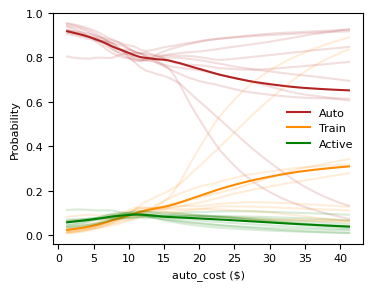

In [ ]:
result('none')

### Utility gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7454, 70.4%
Model 2 : 0.7286, 71.5%
Model 3 : 0.7790, 70.4%
Model 4 : 0.7563, 70.4%
Model 5 : 0.7344, 70.4%
Model 6 : 0.8133, 70.4%
Model 7 : 0.7591, 70.4%
Model 8 : 0.7808, 70.4%
Model 9 : 0.7465, 70.4%
Model 10: 0.7646, 70.4%
------------------------------
Mean test log-likelihood = -2282.4
Mean test accuracy = 70.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,67.3% (2.7%)
1,Train,13.5% (2.3%)
2,Active,19.2% (1.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,67.5% (2.8%)
1,Train,13.5% (2.4%)
2,Active,19.1% (1.3%)


------------------------------
Strong regularity = 0.9915
Weak regularity = 0.9940
------------------------------


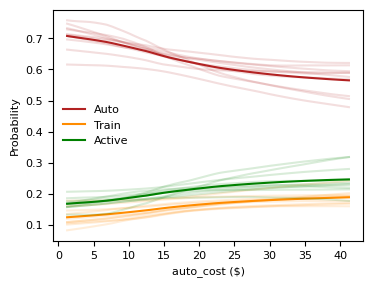

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7002, 72.4%
Model 2 : 0.7032, 71.8%
Model 3 : 0.7424, 70.4%
Model 4 : 0.7091, 70.4%
Model 5 : 0.7187, 70.4%
Model 6 : 0.7488, 70.4%
Model 7 : 0.7245, 70.4%
Model 8 : 0.7245, 70.4%
Model 9 : 0.6994, 71.3%
Model 10: 0.7292, 70.4%
------------------------------
Mean test log-likelihood = -2160.0
Mean test accuracy = 70.8%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.3% (0.5%)
1,Train,10.2% (0.5%)
2,Active,19.5% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.7% (0.5%)
1,Train,10.0% (0.5%)
2,Active,19.3% (0.8%)


------------------------------
Strong regularity = 0.9768
Weak regularity = 0.9803
------------------------------


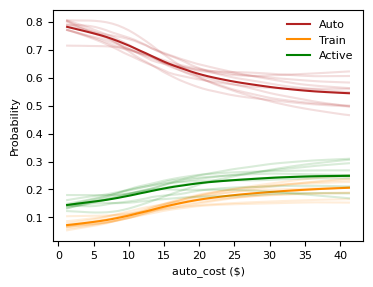

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6635, 72.3%
Model 2 : 0.6609, 72.6%
Model 3 : 0.6840, 72.1%
Model 4 : 0.6599, 72.8%
Model 5 : 0.6644, 72.6%
Model 6 : 0.6668, 72.3%
Model 7 : 0.6775, 72.1%
Model 8 : 0.6673, 72.5%
Model 9 : 0.6592, 72.3%
Model 10: 0.6810, 72.0%
------------------------------
Mean test log-likelihood = -2005.3
Mean test accuracy = 72.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.8% (0.8%)
1,Train,9.7% (0.3%)
2,Active,20.5% (0.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (0.7%)
1,Train,9.5% (0.3%)
2,Active,20.1% (0.5%)


------------------------------
Strong regularity = 0.9684
Weak regularity = 0.9786
------------------------------


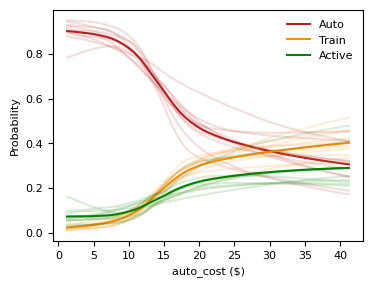

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6400, 73.1%
Model 2 : 0.6384, 73.2%
Model 3 : 0.6455, 72.6%
Model 4 : 0.6422, 72.9%
Model 5 : 0.6408, 72.8%
Model 6 : 0.6405, 72.7%
Model 7 : 0.6420, 72.8%
Model 8 : 0.6368, 72.7%
Model 9 : 0.6391, 72.9%
Model 10: 0.6402, 72.8%
------------------------------
Mean test log-likelihood = -1921.6
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.5% (1.2%)
1,Train,10.2% (0.4%)
2,Active,21.3% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.3% (1.2%)
1,Train,9.9% (0.4%)
2,Active,20.8% (0.8%)


------------------------------
Strong regularity = 0.9491
Weak regularity = 0.9729
------------------------------


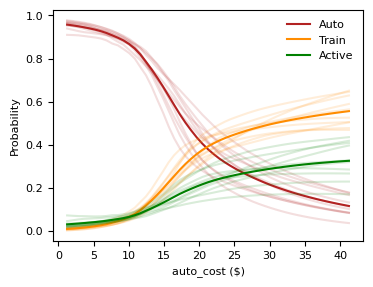

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6354, 73.0%
Model 2 : 0.6328, 73.4%
Model 3 : 0.6383, 72.6%
Model 4 : 0.6370, 73.0%
Model 5 : 0.6341, 73.3%
Model 6 : 0.6341, 73.3%
Model 7 : 0.6377, 73.0%
Model 8 : 0.6370, 72.5%
Model 9 : 0.6342, 72.9%
Model 10: 0.6323, 73.3%
------------------------------
Mean test log-likelihood = -1905.9
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (1.5%)
1,Train,10.6% (0.6%)
2,Active,20.8% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.5% (1.5%)
1,Train,10.2% (0.6%)
2,Active,20.3% (1.1%)


------------------------------
Strong regularity = 0.9277
Weak regularity = 0.9555
------------------------------


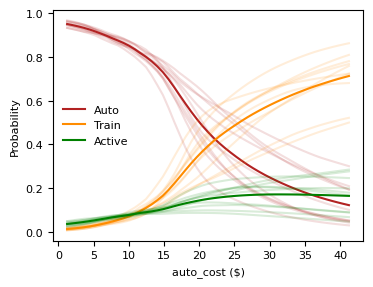

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6345, 73.0%
Model 2 : 0.6318, 73.2%
Model 3 : 0.6350, 72.5%
Model 4 : 0.6385, 72.7%
Model 5 : 0.6320, 73.3%
Model 6 : 0.6346, 73.2%
Model 7 : 0.6370, 72.4%
Model 8 : 0.6343, 72.8%
Model 9 : 0.6366, 72.9%
Model 10: 0.6283, 72.8%
------------------------------
Mean test log-likelihood = -1902.8
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.8% (1.3%)
1,Train,10.6% (0.6%)
2,Active,20.6% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.6% (1.3%)
1,Train,10.2% (0.6%)
2,Active,20.2% (1.0%)


------------------------------
Strong regularity = 0.8888
Weak regularity = 0.9183
------------------------------


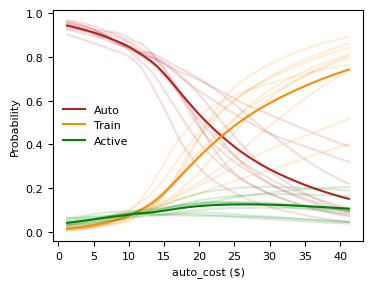

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6328, 73.0%
Model 2 : 0.6326, 73.4%
Model 3 : 0.6403, 72.5%
Model 4 : 0.6380, 72.8%
Model 5 : 0.6339, 73.4%
Model 6 : 0.6318, 73.3%
Model 7 : 0.6375, 72.6%
Model 8 : 0.6334, 72.8%
Model 9 : 0.6364, 72.7%
Model 10: 0.6268, 73.0%
------------------------------
Mean test log-likelihood = -1903.1
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.5% (1.7%)
1,Train,10.6% (0.8%)
2,Active,20.9% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.3% (1.7%)
1,Train,10.3% (0.8%)
2,Active,20.5% (1.2%)


------------------------------
Strong regularity = 0.8496
Weak regularity = 0.8815
------------------------------


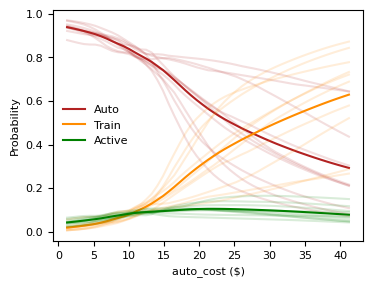

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6317, 73.1%
Model 2 : 0.6327, 73.3%
Model 3 : 0.6392, 72.7%
Model 4 : 0.6383, 72.7%
Model 5 : 0.6331, 73.3%
Model 6 : 0.6337, 73.3%
Model 7 : 0.6364, 72.4%
Model 8 : 0.6333, 72.6%
Model 9 : 0.6353, 72.8%
Model 10: 0.6275, 72.8%
------------------------------
Mean test log-likelihood = -1902.4
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.6% (1.6%)
1,Train,10.4% (0.7%)
2,Active,21.0% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.3% (1.5%)
1,Train,10.1% (0.7%)
2,Active,20.6% (1.2%)


------------------------------
Strong regularity = 0.7415
Weak regularity = 0.7779
------------------------------


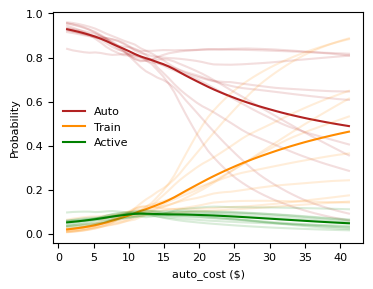

------------------------------ 
Model comparison:


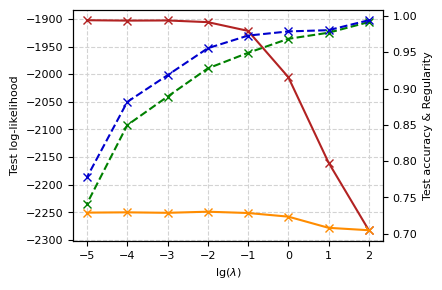

In [ ]:
# With sum
result('util', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.8381, 70.4%
Model 2 : 0.8449, 70.4%
Model 3 : 0.8510, 70.4%
Model 4 : 0.8681, 70.4%
Model 5 : 0.8407, 70.4%
Model 6 : 0.8574, 70.4%
Model 7 : 0.8418, 70.4%
Model 8 : 0.8469, 70.4%
Model 9 : 0.8357, 70.4%
Model 10: 0.8310, 70.4%
------------------------------
Mean test log-likelihood = -2536.7
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,57.2% (1.5%)
1,Train,20.1% (1.4%)
2,Active,22.7% (0.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,57.2% (1.5%)
1,Train,20.1% (1.4%)
2,Active,22.7% (0.6%)


------------------------------
Strong regularity = 0.0003
Weak regularity = 0.9998
------------------------------


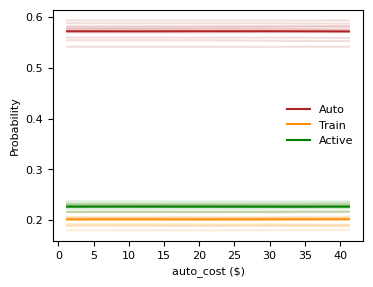

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7975, 70.4%
Model 2 : 0.7979, 70.4%
Model 3 : 0.7989, 70.4%
Model 4 : 0.7983, 70.4%
Model 5 : 0.7965, 70.4%
Model 6 : 0.7994, 70.4%
Model 7 : 0.7983, 70.4%
Model 8 : 0.7971, 70.4%
Model 9 : 0.7984, 70.4%
Model 10: 0.7986, 70.4%
------------------------------
Mean test log-likelihood = -2394.2
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.5% (0.2%)
1,Train,10.4% (0.2%)
2,Active,20.0% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.5% (0.2%)
1,Train,10.4% (0.2%)
2,Active,20.0% (0.1%)


------------------------------
Strong regularity = 0.0020
Weak regularity = 0.9936
------------------------------


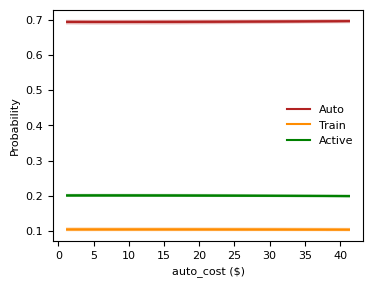

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7261, 70.5%
Model 2 : 0.7273, 71.0%
Model 3 : 0.7268, 70.4%
Model 4 : 0.7301, 70.4%
Model 5 : 0.7318, 70.4%
Model 6 : 0.7353, 70.4%
Model 7 : 0.7311, 70.4%
Model 8 : 0.7292, 70.4%
Model 9 : 0.7243, 70.4%
Model 10: 0.7265, 71.0%
------------------------------
Mean test log-likelihood = -2186.6
Mean test accuracy = 70.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.6% (0.2%)
1,Train,10.1% (0.2%)
2,Active,20.3% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.8% (0.3%)
1,Train,10.0% (0.2%)
2,Active,20.2% (0.3%)


------------------------------
Strong regularity = 0.0058
Weak regularity = 0.0577
------------------------------


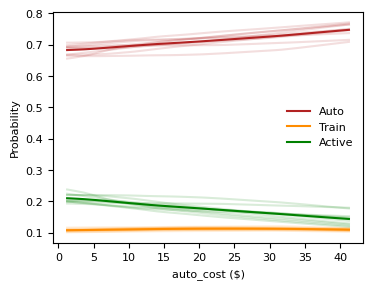

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6838, 72.6%
Model 2 : 0.6867, 72.5%
Model 3 : 0.6857, 72.6%
Model 4 : 0.6875, 72.2%
Model 5 : 0.6886, 72.4%
Model 6 : 0.6886, 72.4%
Model 7 : 0.6864, 72.5%
Model 8 : 0.6829, 72.7%
Model 9 : 0.6834, 72.7%
Model 10: 0.6816, 72.3%
------------------------------
Mean test log-likelihood = -2056.5
Mean test accuracy = 72.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.3% (0.5%)
1,Train,9.8% (0.1%)
2,Active,20.9% (0.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.7% (0.5%)
1,Train,9.7% (0.1%)
2,Active,20.6% (0.4%)


------------------------------
Strong regularity = 0.0296
Weak regularity = 0.0737
------------------------------


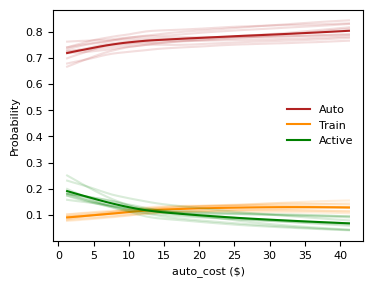

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6589, 72.6%
Model 2 : 0.6607, 72.8%
Model 3 : 0.6624, 72.3%
Model 4 : 0.6601, 72.3%
Model 5 : 0.6615, 72.7%
Model 6 : 0.6609, 72.6%
Model 7 : 0.6621, 72.8%
Model 8 : 0.6602, 72.8%
Model 9 : 0.6587, 72.5%
Model 10: 0.6642, 72.5%
------------------------------
Mean test log-likelihood = -1982.9
Mean test accuracy = 72.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.5% (0.9%)
1,Train,9.7% (0.2%)
2,Active,20.8% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.9% (0.9%)
1,Train,9.6% (0.2%)
2,Active,20.5% (0.7%)


------------------------------
Strong regularity = 0.3807
Weak regularity = 0.4295
------------------------------


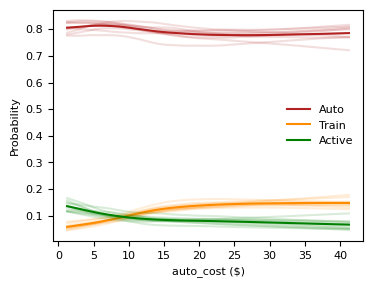

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6469, 73.1%
Model 2 : 0.6472, 73.1%
Model 3 : 0.6508, 72.6%
Model 4 : 0.6501, 73.1%
Model 5 : 0.6483, 72.8%
Model 6 : 0.6491, 73.4%
Model 7 : 0.6488, 72.9%
Model 8 : 0.6493, 72.7%
Model 9 : 0.6442, 72.9%
Model 10: 0.6500, 72.9%
------------------------------
Mean test log-likelihood = -1945.5
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.1% (1.0%)
1,Train,9.9% (0.3%)
2,Active,21.0% (0.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.6% (1.0%)
1,Train,9.8% (0.3%)
2,Active,20.6% (0.7%)


------------------------------
Strong regularity = 0.6004
Weak regularity = 0.6476
------------------------------


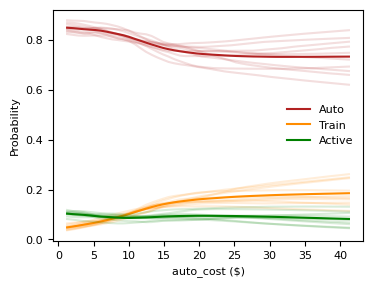

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6394, 73.0%
Model 2 : 0.6380, 73.1%
Model 3 : 0.6426, 72.8%
Model 4 : 0.6443, 72.8%
Model 5 : 0.6406, 72.7%
Model 6 : 0.6414, 73.0%
Model 7 : 0.6452, 72.9%
Model 8 : 0.6415, 73.0%
Model 9 : 0.6385, 73.1%
Model 10: 0.6384, 72.9%
------------------------------
Mean test log-likelihood = -1923.0
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.1% (1.1%)
1,Train,9.9% (0.4%)
2,Active,20.9% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.7% (1.1%)
1,Train,9.9% (0.4%)
2,Active,20.5% (0.8%)


------------------------------
Strong regularity = 0.5667
Weak regularity = 0.6091
------------------------------


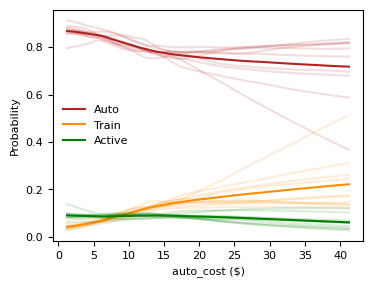

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6353, 72.9%
Model 2 : 0.6361, 73.1%
Model 3 : 0.6371, 73.1%
Model 4 : 0.6409, 73.1%
Model 5 : 0.6369, 72.8%
Model 6 : 0.6376, 73.1%
Model 7 : 0.6415, 72.8%
Model 8 : 0.6378, 72.8%
Model 9 : 0.6369, 72.6%
Model 10: 0.6344, 72.7%
------------------------------
Mean test log-likelihood = -1912.3
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.1% (1.1%)
1,Train,10.1% (0.6%)
2,Active,20.8% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.7% (1.1%)
1,Train,9.9% (0.6%)
2,Active,20.4% (0.8%)


------------------------------
Strong regularity = 0.5502
Weak regularity = 0.5865
------------------------------


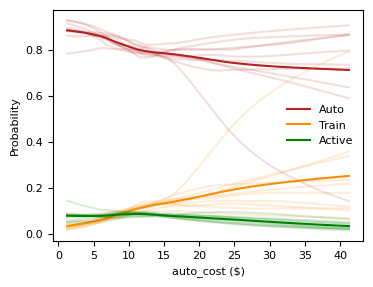

------------------------------ 
Model comparison:


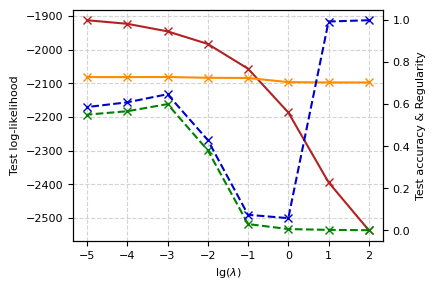

In [ ]:
# With norm
result('util', [np.power(10, i) for i in np.arange(2, -6, -1.0)], False)

### Probability gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.8109, 70.4%
Model 2 : 0.8551, 70.4%
Model 3 : 0.8861, 70.4%
Model 4 : 0.7771, 70.4%
Model 5 : 0.7568, 70.4%
Model 6 : 0.9388, 70.4%
Model 7 : 0.7650, 70.4%
Model 8 : 0.8102, 70.4%
Model 9 : 0.7937, 70.4%
Model 10: 0.8446, 70.4%
------------------------------
Mean test log-likelihood = -2471.5
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,59.6% (7.9%)
1,Train,18.6% (4.7%)
2,Active,21.8% (4.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,59.8% (8.0%)
1,Train,18.5% (4.7%)
2,Active,21.7% (4.1%)


------------------------------
Strong regularity = 0.9994
Weak regularity = 0.9995
------------------------------


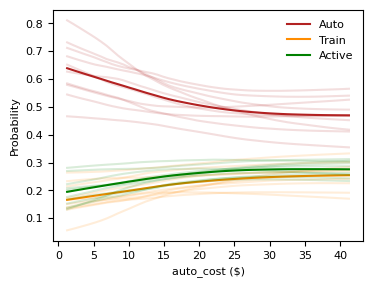

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7074, 71.8%
Model 2 : 0.7010, 71.5%
Model 3 : 0.7186, 70.4%
Model 4 : 0.7114, 70.4%
Model 5 : 0.7084, 70.3%
Model 6 : 0.7449, 70.4%
Model 7 : 0.7008, 71.5%
Model 8 : 0.7069, 71.2%
Model 9 : 0.6913, 71.9%
Model 10: 0.7215, 70.4%
------------------------------
Mean test log-likelihood = -2133.6
Mean test accuracy = 70.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.4% (0.8%)
1,Train,10.2% (0.4%)
2,Active,19.4% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.9% (0.7%)
1,Train,10.0% (0.4%)
2,Active,19.1% (0.8%)


------------------------------
Strong regularity = 0.9987
Weak regularity = 1.0000
------------------------------


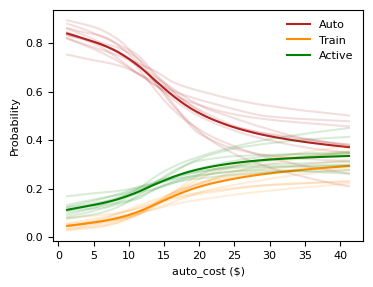

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6552, 72.5%
Model 2 : 0.6469, 72.9%
Model 3 : 0.6479, 73.0%
Model 4 : 0.6524, 72.6%
Model 5 : 0.6459, 72.6%
Model 6 : 0.6599, 72.8%
Model 7 : 0.6468, 72.8%
Model 8 : 0.6463, 73.0%
Model 9 : 0.6473, 72.9%
Model 10: 0.6606, 72.2%
------------------------------
Mean test log-likelihood = -1952.8
Mean test accuracy = 72.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.4% (1.2%)
1,Train,10.4% (0.7%)
2,Active,21.2% (0.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.2% (1.2%)
1,Train,10.0% (0.7%)
2,Active,20.7% (0.9%)


------------------------------
Strong regularity = 0.9800
Weak regularity = 1.0000
------------------------------


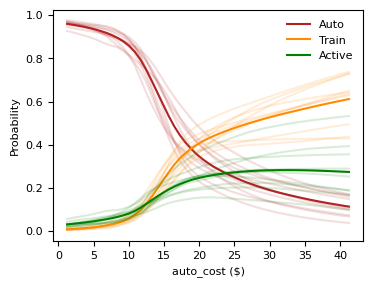

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6377, 73.2%
Model 2 : 0.6356, 72.6%
Model 3 : 0.6447, 72.5%
Model 4 : 0.6415, 73.1%
Model 5 : 0.6356, 73.0%
Model 6 : 0.6349, 73.3%
Model 7 : 0.6382, 73.0%
Model 8 : 0.6383, 72.4%
Model 9 : 0.6384, 72.8%
Model 10: 0.6346, 72.7%
------------------------------
Mean test log-likelihood = -1913.8
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.4% (1.5%)
1,Train,10.6% (0.6%)
2,Active,21.0% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.2% (1.5%)
1,Train,10.2% (0.6%)
2,Active,20.5% (1.1%)


------------------------------
Strong regularity = 0.9793
Weak regularity = 0.9998
------------------------------


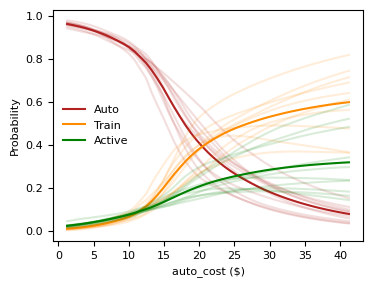

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6362, 73.3%
Model 2 : 0.6328, 73.3%
Model 3 : 0.6395, 72.4%
Model 4 : 0.6381, 73.0%
Model 5 : 0.6336, 73.6%
Model 6 : 0.6328, 73.4%
Model 7 : 0.6393, 72.4%
Model 8 : 0.6355, 72.8%
Model 9 : 0.6354, 72.8%
Model 10: 0.6302, 72.8%
------------------------------
Mean test log-likelihood = -1906.0
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.6% (1.6%)
1,Train,10.6% (0.8%)
2,Active,20.8% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.5% (1.6%)
1,Train,10.2% (0.8%)
2,Active,20.3% (1.1%)


------------------------------
Strong regularity = 0.9772
Weak regularity = 0.9973
------------------------------


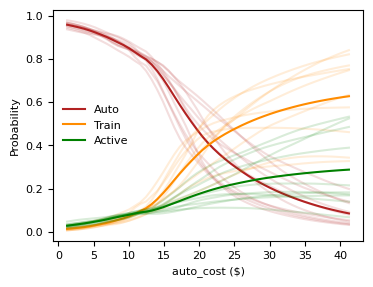

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6337, 73.3%
Model 2 : 0.6306, 73.5%
Model 3 : 0.6407, 72.6%
Model 4 : 0.6366, 73.2%
Model 5 : 0.6344, 73.0%
Model 6 : 0.6301, 73.5%
Model 7 : 0.6364, 72.7%
Model 8 : 0.6363, 72.6%
Model 9 : 0.6355, 72.6%
Model 10: 0.6287, 72.6%
------------------------------
Mean test log-likelihood = -1902.9
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.5% (1.5%)
1,Train,10.6% (0.6%)
2,Active,20.9% (1.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.3% (1.5%)
1,Train,10.2% (0.6%)
2,Active,20.4% (1.2%)


------------------------------
Strong regularity = 0.9613
Weak regularity = 0.9841
------------------------------


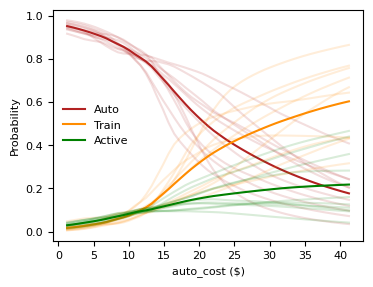

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6318, 72.8%
Model 2 : 0.6323, 73.4%
Model 3 : 0.6405, 72.5%
Model 4 : 0.6387, 72.9%
Model 5 : 0.6336, 73.3%
Model 6 : 0.6331, 73.6%
Model 7 : 0.6383, 72.6%
Model 8 : 0.6337, 72.8%
Model 9 : 0.6343, 72.7%
Model 10: 0.6276, 72.8%
------------------------------
Mean test log-likelihood = -1903.2
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.5% (1.6%)
1,Train,10.4% (0.8%)
2,Active,21.1% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.2% (1.5%)
1,Train,10.2% (0.7%)
2,Active,20.6% (1.1%)


------------------------------
Strong regularity = 0.8639
Weak regularity = 0.8972
------------------------------


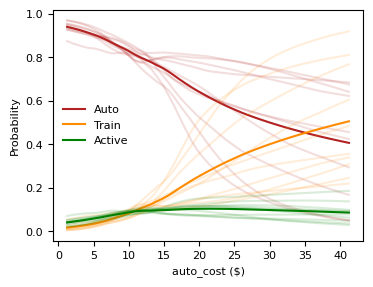

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6312, 73.4%
Model 2 : 0.6328, 73.5%
Model 3 : 0.6378, 72.7%
Model 4 : 0.6376, 72.8%
Model 5 : 0.6331, 73.3%
Model 6 : 0.6337, 73.2%
Model 7 : 0.6378, 72.3%
Model 8 : 0.6344, 72.7%
Model 9 : 0.6351, 73.0%
Model 10: 0.6281, 72.9%
------------------------------
Mean test log-likelihood = -1902.5
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.6% (1.5%)
1,Train,10.3% (0.7%)
2,Active,21.0% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.3% (1.5%)
1,Train,10.1% (0.7%)
2,Active,20.5% (1.1%)


------------------------------
Strong regularity = 0.7206
Weak regularity = 0.7555
------------------------------


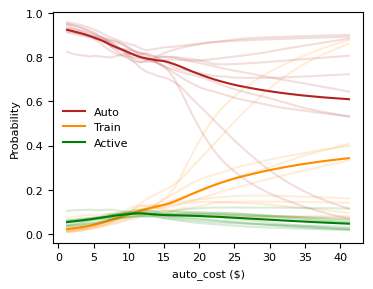

------------------------------ 
Model comparison:


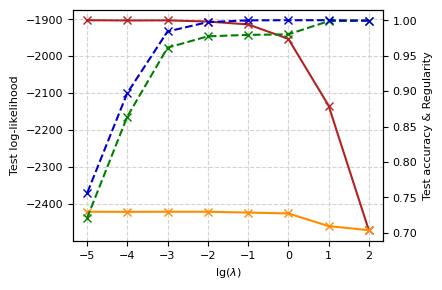

In [ ]:
# With sum
result('prob', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 1000.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.8784, 70.4%
Model 2 : 0.8570, 70.4%
Model 3 : 0.8911, 70.4%
Model 4 : 0.8920, 70.4%
Model 5 : 0.8705, 70.4%
Model 6 : 0.9129, 70.4%
Model 7 : 0.8710, 70.4%
Model 8 : 0.8918, 70.4%
Model 9 : 0.8488, 70.4%
Model 10: 0.8323, 70.4%
------------------------------
Mean test log-likelihood = -2623.8
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,52.9% (3.2%)
1,Train,22.3% (1.9%)
2,Active,24.9% (1.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,52.9% (3.2%)
1,Train,22.3% (1.9%)
2,Active,24.9% (1.6%)


------------------------------
Strong regularity = 0.0000
Weak regularity = 0.9999
------------------------------


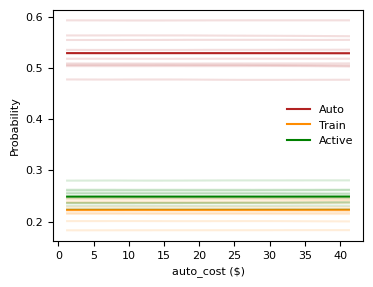

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7975, 70.4%
Model 2 : 0.7984, 70.4%
Model 3 : 0.7994, 70.4%
Model 4 : 0.7989, 70.4%
Model 5 : 0.7961, 70.4%
Model 6 : 0.8000, 70.4%
Model 7 : 0.7981, 70.4%
Model 8 : 0.7961, 70.4%
Model 9 : 0.7989, 70.4%
Model 10: 0.7986, 70.4%
------------------------------
Mean test log-likelihood = -2394.6
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (0.2%)
1,Train,9.8% (0.1%)
2,Active,20.3% (0.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.9% (0.2%)
1,Train,9.8% (0.1%)
2,Active,20.3% (0.1%)


------------------------------
Strong regularity = 0.0033
Weak regularity = 0.9957
------------------------------


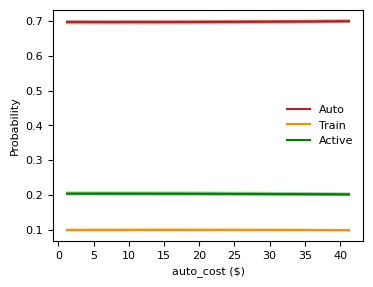

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7311, 70.4%
Model 2 : 0.7335, 70.4%
Model 3 : 0.7340, 70.4%
Model 4 : 0.7389, 70.4%
Model 5 : 0.7364, 70.4%
Model 6 : 0.7448, 70.4%
Model 7 : 0.7360, 70.4%
Model 8 : 0.7276, 70.4%
Model 9 : 0.7299, 70.4%
Model 10: 0.7305, 70.4%
------------------------------
Mean test log-likelihood = -2202.8
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,71.1% (0.2%)
1,Train,9.2% (0.2%)
2,Active,19.6% (0.2%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,71.3% (0.2%)
1,Train,9.2% (0.2%)
2,Active,19.5% (0.2%)


------------------------------
Strong regularity = 0.2440
Weak regularity = 0.7600
------------------------------


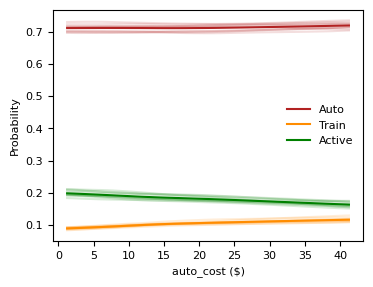

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7021, 71.8%
Model 2 : 0.7000, 72.0%
Model 3 : 0.7027, 72.2%
Model 4 : 0.7053, 71.6%
Model 5 : 0.7043, 71.9%
Model 6 : 0.7024, 71.9%
Model 7 : 0.7036, 71.8%
Model 8 : 0.7028, 71.8%
Model 9 : 0.7026, 72.0%
Model 10: 0.7021, 71.7%
------------------------------
Mean test log-likelihood = -2108.4
Mean test accuracy = 71.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.6% (0.3%)
1,Train,9.0% (0.2%)
2,Active,20.4% (0.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.9% (0.3%)
1,Train,9.0% (0.2%)
2,Active,20.1% (0.3%)


------------------------------
Strong regularity = 0.3530
Weak regularity = 0.5723
------------------------------


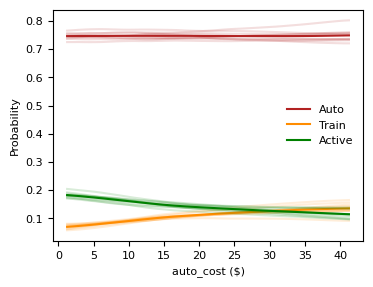

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6849, 72.8%
Model 2 : 0.6836, 72.7%
Model 3 : 0.6855, 72.6%
Model 4 : 0.6851, 72.5%
Model 5 : 0.6887, 72.4%
Model 6 : 0.6829, 72.7%
Model 7 : 0.6851, 72.5%
Model 8 : 0.6872, 72.2%
Model 9 : 0.6841, 72.6%
Model 10: 0.6857, 72.7%
------------------------------
Mean test log-likelihood = -2055.8
Mean test accuracy = 72.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.2% (0.9%)
1,Train,9.2% (0.5%)
2,Active,20.5% (0.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.6% (0.9%)
1,Train,9.2% (0.5%)
2,Active,20.2% (0.5%)


------------------------------
Strong regularity = 0.5042
Weak regularity = 0.5837
------------------------------


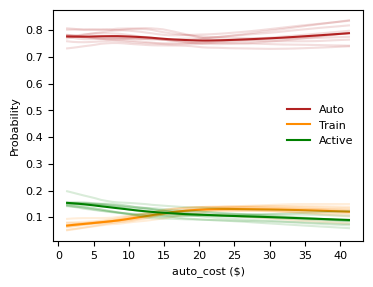

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6671, 73.0%
Model 2 : 0.6650, 73.2%
Model 3 : 0.6681, 72.6%
Model 4 : 0.6677, 72.6%
Model 5 : 0.6685, 72.7%
Model 6 : 0.6666, 73.1%
Model 7 : 0.6678, 72.9%
Model 8 : 0.6704, 72.6%
Model 9 : 0.6674, 72.9%
Model 10: 0.6679, 72.8%
------------------------------
Mean test log-likelihood = -2003.0
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.3% (1.4%)
1,Train,9.1% (0.7%)
2,Active,20.6% (0.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.7% (1.4%)
1,Train,9.0% (0.7%)
2,Active,20.3% (0.9%)


------------------------------
Strong regularity = 0.5060
Weak regularity = 0.5424
------------------------------


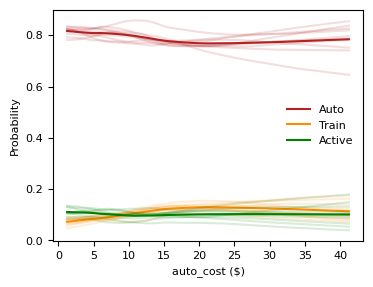

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6479, 73.0%
Model 2 : 0.6479, 73.2%
Model 3 : 0.6477, 73.1%
Model 4 : 0.6501, 73.2%
Model 5 : 0.6514, 73.1%
Model 6 : 0.6503, 73.2%
Model 7 : 0.6524, 72.7%
Model 8 : 0.6503, 72.7%
Model 9 : 0.6491, 73.2%
Model 10: 0.6486, 73.1%
------------------------------
Mean test log-likelihood = -1948.7
Mean test accuracy = 73.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (1.3%)
1,Train,9.0% (0.5%)
2,Active,21.0% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.6% (1.3%)
1,Train,8.9% (0.5%)
2,Active,20.5% (1.0%)


------------------------------
Strong regularity = 0.5167
Weak regularity = 0.5509
------------------------------


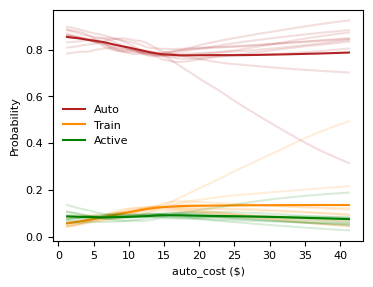

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6356, 73.3%
Model 2 : 0.6369, 73.5%
Model 3 : 0.6361, 72.9%
Model 4 : 0.6401, 73.1%
Model 5 : 0.6370, 72.9%
Model 6 : 0.6370, 73.2%
Model 7 : 0.6406, 72.9%
Model 8 : 0.6372, 73.0%
Model 9 : 0.6383, 72.9%
Model 10: 0.6337, 73.1%
------------------------------
Mean test log-likelihood = -1911.8
Mean test accuracy = 73.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.5% (1.0%)
1,Train,9.5% (0.6%)
2,Active,21.0% (0.7%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.1% (1.0%)
1,Train,9.4% (0.5%)
2,Active,20.5% (0.7%)


------------------------------
Strong regularity = 0.5181
Weak regularity = 0.5548
------------------------------


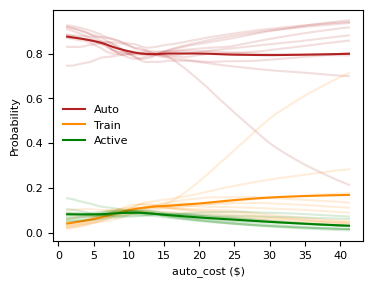

------------------------------ 
Model comparison:


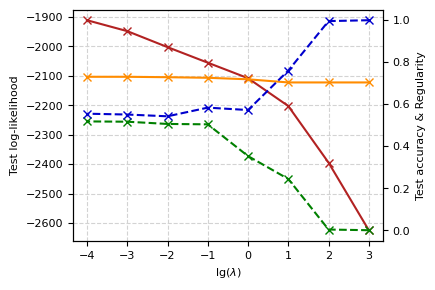

In [ ]:
# With norm
result('prob', [np.power(10, i) for i in np.arange(3, -5, -1.0)], False)

### Loss gradient regularization

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.8905, 70.4%
Model 2 : 0.9371, 70.4%
Model 3 : 0.9485, 70.4%
Model 4 : 0.9006, 70.4%
Model 5 : 0.8564, 70.3%
Model 6 : 0.9935, 70.3%
Model 7 : 0.7931, 70.4%
Model 8 : 0.7989, 70.4%
Model 9 : 0.8578, 70.4%
Model 10: 0.8929, 70.4%
------------------------------
Mean test log-likelihood = -2660.8
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,50.6% (6.2%)
1,Train,23.6% (4.2%)
2,Active,25.8% (3.3%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,50.7% (6.3%)
1,Train,23.5% (4.2%)
2,Active,25.8% (3.3%)


------------------------------
Strong regularity = 0.9999
Weak regularity = 0.9999
------------------------------


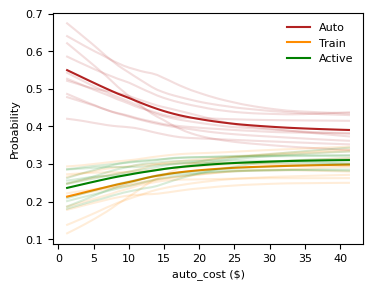

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7148, 70.4%
Model 2 : 0.7044, 71.7%
Model 3 : 0.7234, 70.4%
Model 4 : 0.7194, 70.4%
Model 5 : 0.7224, 70.3%
Model 6 : 0.7480, 70.4%
Model 7 : 0.7171, 70.4%
Model 8 : 0.7181, 70.4%
Model 9 : 0.7101, 70.4%
Model 10: 0.7184, 70.4%
------------------------------
Mean test log-likelihood = -2158.9
Mean test accuracy = 70.5%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.4% (0.8%)
1,Train,10.4% (0.5%)
2,Active,19.2% (0.8%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.9% (0.8%)
1,Train,10.2% (0.5%)
2,Active,18.9% (0.8%)


------------------------------
Strong regularity = 0.9992
Weak regularity = 0.9999
------------------------------


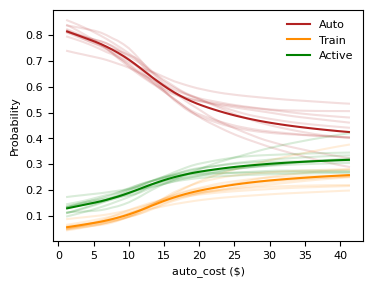

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6613, 72.3%
Model 2 : 0.6580, 73.1%
Model 3 : 0.6555, 72.5%
Model 4 : 0.6590, 72.5%
Model 5 : 0.6580, 72.8%
Model 6 : 0.6672, 72.2%
Model 7 : 0.6547, 72.8%
Model 8 : 0.6466, 73.0%
Model 9 : 0.6507, 73.1%
Model 10: 0.6621, 72.3%
------------------------------
Mean test log-likelihood = -1971.9
Mean test accuracy = 72.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.9% (0.8%)
1,Train,10.9% (0.5%)
2,Active,20.2% (0.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.7% (0.8%)
1,Train,10.5% (0.5%)
2,Active,19.8% (0.9%)


------------------------------
Strong regularity = 0.9815
Weak regularity = 0.9999
------------------------------


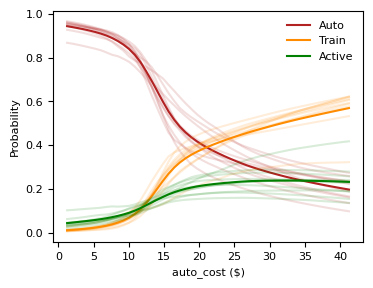

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6373, 73.4%
Model 2 : 0.6389, 73.0%
Model 3 : 0.6418, 72.3%
Model 4 : 0.6415, 73.2%
Model 5 : 0.6360, 72.9%
Model 6 : 0.6373, 72.9%
Model 7 : 0.6383, 72.7%
Model 8 : 0.6392, 72.7%
Model 9 : 0.6392, 72.8%
Model 10: 0.6355, 72.9%
------------------------------
Mean test log-likelihood = -1915.5
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.2% (1.3%)
1,Train,10.5% (0.5%)
2,Active,21.3% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.1% (1.3%)
1,Train,10.1% (0.5%)
2,Active,20.8% (0.9%)


------------------------------
Strong regularity = 0.9791
Weak regularity = 0.9996
------------------------------


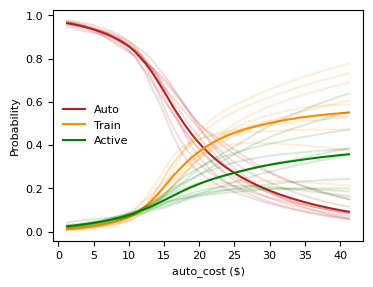

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6362, 73.4%
Model 2 : 0.6312, 73.3%
Model 3 : 0.6374, 72.5%
Model 4 : 0.6377, 73.1%
Model 5 : 0.6345, 73.4%
Model 6 : 0.6328, 73.4%
Model 7 : 0.6384, 72.6%
Model 8 : 0.6352, 72.6%
Model 9 : 0.6360, 72.8%
Model 10: 0.6301, 72.8%
------------------------------
Mean test log-likelihood = -1904.9
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.6% (1.5%)
1,Train,10.7% (0.7%)
2,Active,20.7% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.4% (1.5%)
1,Train,10.3% (0.7%)
2,Active,20.2% (1.0%)


------------------------------
Strong regularity = 0.9758
Weak regularity = 0.9970
------------------------------


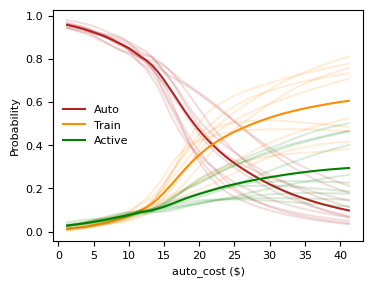

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6349, 73.0%
Model 2 : 0.6318, 73.4%
Model 3 : 0.6422, 72.5%
Model 4 : 0.6400, 72.9%
Model 5 : 0.6346, 73.2%
Model 6 : 0.6336, 73.2%
Model 7 : 0.6370, 72.5%
Model 8 : 0.6356, 72.6%
Model 9 : 0.6359, 72.8%
Model 10: 0.6281, 72.9%
------------------------------
Mean test log-likelihood = -1906.1
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.4% (1.6%)
1,Train,10.7% (0.7%)
2,Active,20.9% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.3% (1.6%)
1,Train,10.4% (0.7%)
2,Active,20.4% (1.1%)


------------------------------
Strong regularity = 0.9603
Weak regularity = 0.9847
------------------------------


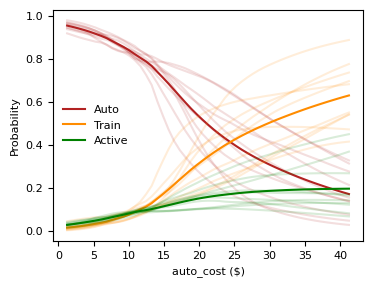

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6320, 73.0%
Model 2 : 0.6328, 73.5%
Model 3 : 0.6405, 72.6%
Model 4 : 0.6379, 72.9%
Model 5 : 0.6336, 73.3%
Model 6 : 0.6338, 73.2%
Model 7 : 0.6380, 72.6%
Model 8 : 0.6337, 72.9%
Model 9 : 0.6338, 72.8%
Model 10: 0.6273, 73.0%
------------------------------
Mean test log-likelihood = -1903.0
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.4% (1.6%)
1,Train,10.5% (0.8%)
2,Active,21.1% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.2% (1.6%)
1,Train,10.2% (0.7%)
2,Active,20.6% (1.1%)


------------------------------
Strong regularity = 0.8645
Weak regularity = 0.8976
------------------------------


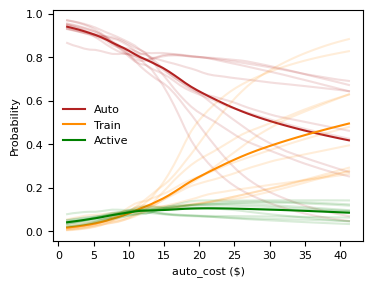

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6318, 73.2%
Model 2 : 0.6328, 73.4%
Model 3 : 0.6382, 72.7%
Model 4 : 0.6374, 72.8%
Model 5 : 0.6333, 73.2%
Model 6 : 0.6342, 73.1%
Model 7 : 0.6375, 72.4%
Model 8 : 0.6340, 72.7%
Model 9 : 0.6346, 72.8%
Model 10: 0.6285, 72.7%
------------------------------
Mean test log-likelihood = -1902.6
Mean test accuracy = 72.9%
------------------------------ 
Training set:


,Mode,Share
0,Auto,68.6% (1.5%)
1,Train,10.4% (0.7%)
2,Active,21.0% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.3% (1.5%)
1,Train,10.2% (0.7%)
2,Active,20.5% (1.1%)


------------------------------
Strong regularity = 0.7211
Weak regularity = 0.7551
------------------------------


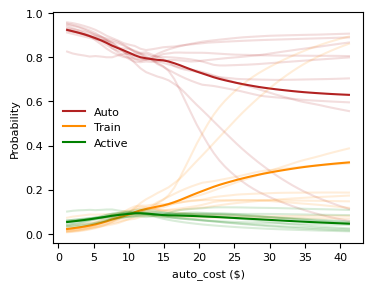

------------------------------ 
Model comparison:


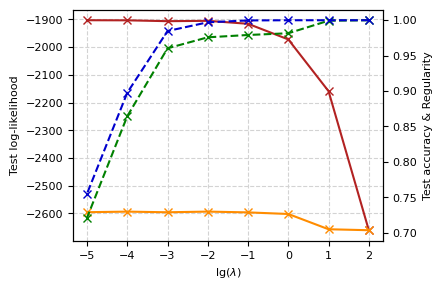

In [ ]:
# With sum
result('loss', [np.power(10, i) for i in np.arange(2, -6, -1.0)])

Penalty = 1000.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.9941, 70.4%
Model 2 : 0.9978, 70.4%
Model 3 : 0.9753, 70.4%
Model 4 : 1.0168, 70.4%
Model 5 : 1.0086, 70.4%
Model 6 : 1.0237, 70.4%
Model 7 : 0.9945, 70.4%
Model 8 : 1.0230, 70.4%
Model 9 : 0.9560, 70.4%
Model 10: 0.9639, 70.4%
------------------------------
Mean test log-likelihood = -2986.0
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,40.4% (1.7%)
1,Train,29.2% (1.7%)
2,Active,30.3% (1.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,40.4% (1.7%)
1,Train,29.2% (1.7%)
2,Active,30.3% (1.0%)


------------------------------
Strong regularity = 0.0002
Weak regularity = 0.9999
------------------------------


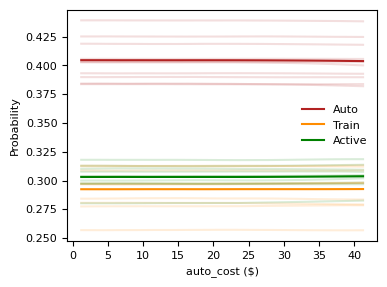

Penalty = 100.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.8030, 70.4%
Model 2 : 0.8027, 70.4%
Model 3 : 0.8029, 70.4%
Model 4 : 0.8476, 70.4%
Model 5 : 0.8008, 70.4%
Model 6 : 0.8254, 70.4%
Model 7 : 0.8003, 70.4%
Model 8 : 0.8001, 70.4%
Model 9 : 0.8012, 70.4%
Model 10: 0.8007, 70.4%
------------------------------
Mean test log-likelihood = -2425.4
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,66.6% (4.3%)
1,Train,13.3% (2.7%)
2,Active,20.1% (1.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,66.6% (4.3%)
1,Train,13.3% (2.7%)
2,Active,20.1% (1.6%)


------------------------------
Strong regularity = 0.0008
Weak regularity = 0.9987
------------------------------


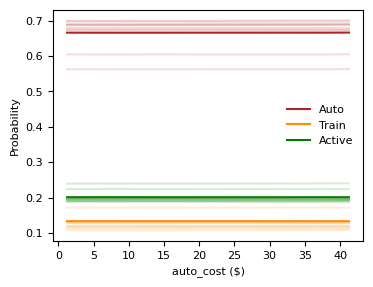

Penalty = 10.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7796, 70.4%
Model 2 : 0.7710, 70.4%
Model 3 : 0.7803, 70.4%
Model 4 : 0.7815, 70.4%
Model 5 : 0.7738, 70.4%
Model 6 : 0.7909, 70.4%
Model 7 : 0.7783, 70.4%
Model 8 : 0.7759, 70.4%
Model 9 : 0.7745, 70.4%
Model 10: 0.7795, 70.4%
------------------------------
Mean test log-likelihood = -2335.6
Mean test accuracy = 70.4%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.9% (0.1%)
1,Train,10.4% (0.1%)
2,Active,19.7% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.9% (0.1%)
1,Train,10.4% (0.1%)
2,Active,19.6% (0.1%)


------------------------------
Strong regularity = 0.1147
Weak regularity = 0.8361
------------------------------


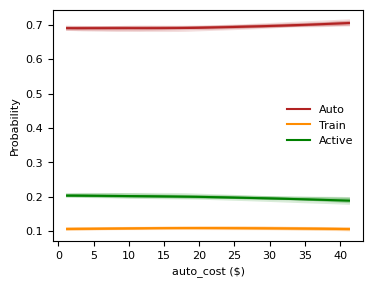

Penalty = 1.0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7167, 71.3%
Model 2 : 0.7151, 71.1%
Model 3 : 0.7180, 70.3%
Model 4 : 0.7175, 70.9%
Model 5 : 0.7232, 70.4%
Model 6 : 0.7221, 70.4%
Model 7 : 0.7207, 70.4%
Model 8 : 0.7189, 70.9%
Model 9 : 0.7203, 70.4%
Model 10: 0.7150, 71.1%
------------------------------
Mean test log-likelihood = -2156.2
Mean test accuracy = 70.7%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (0.4%)
1,Train,10.0% (0.1%)
2,Active,20.0% (0.4%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.2% (0.4%)
1,Train,10.0% (0.1%)
2,Active,19.8% (0.4%)


------------------------------
Strong regularity = 0.4031
Weak regularity = 0.6618
------------------------------


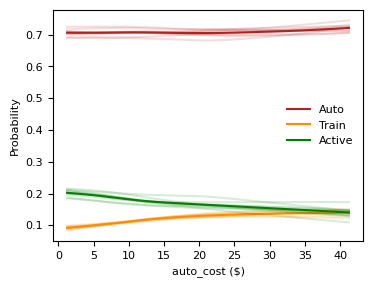

Penalty = 0.1
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6962, 72.3%
Model 2 : 0.6934, 72.0%
Model 3 : 0.6940, 72.5%
Model 4 : 0.6969, 72.4%
Model 5 : 0.6945, 72.2%
Model 6 : 0.6935, 72.3%
Model 7 : 0.6942, 72.0%
Model 8 : 0.6943, 72.3%
Model 9 : 0.6944, 72.2%
Model 10: 0.6941, 72.3%
------------------------------
Mean test log-likelihood = -2083.6
Mean test accuracy = 72.2%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.5% (0.6%)
1,Train,10.1% (0.4%)
2,Active,20.4% (0.5%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.8% (0.6%)
1,Train,10.0% (0.4%)
2,Active,20.1% (0.5%)


------------------------------
Strong regularity = 0.4676
Weak regularity = 0.5670
------------------------------


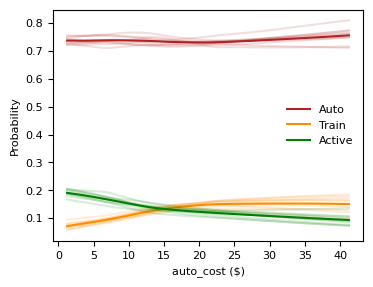

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6787, 72.7%
Model 2 : 0.6764, 72.7%
Model 3 : 0.6773, 72.9%
Model 4 : 0.6797, 72.6%
Model 5 : 0.6797, 72.5%
Model 6 : 0.6758, 72.6%
Model 7 : 0.6779, 72.4%
Model 8 : 0.6785, 72.5%
Model 9 : 0.6771, 72.6%
Model 10: 0.6771, 72.8%
------------------------------
Mean test log-likelihood = -2033.4
Mean test accuracy = 72.6%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.3% (0.8%)
1,Train,10.1% (0.4%)
2,Active,20.6% (0.6%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.7% (0.8%)
1,Train,10.0% (0.4%)
2,Active,20.3% (0.6%)


------------------------------
Strong regularity = 0.4436
Weak regularity = 0.4830
------------------------------


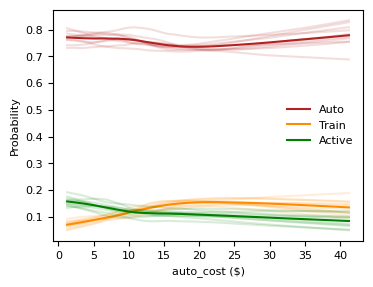

Penalty = 0.001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6604, 72.6%
Model 2 : 0.6580, 73.0%
Model 3 : 0.6604, 72.9%
Model 4 : 0.6612, 73.2%
Model 5 : 0.6603, 72.9%
Model 6 : 0.6615, 73.0%
Model 7 : 0.6623, 72.9%
Model 8 : 0.6613, 73.0%
Model 9 : 0.6596, 72.9%
Model 10: 0.6596, 73.1%
------------------------------
Mean test log-likelihood = -1981.4
Mean test accuracy = 73.0%
------------------------------ 
Training set:


,Mode,Share
0,Auto,70.0% (1.3%)
1,Train,9.8% (0.7%)
2,Active,20.2% (0.9%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.3%)
1,Train,9.8% (0.6%)
2,Active,19.8% (0.9%)


------------------------------
Strong regularity = 0.5079
Weak regularity = 0.5347
------------------------------


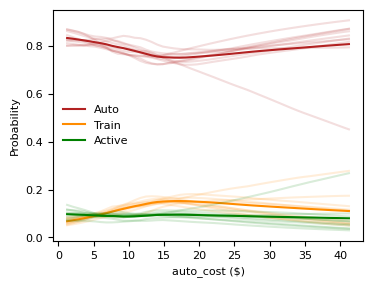

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.6450, 73.4%
Model 2 : 0.6431, 73.4%
Model 3 : 0.6442, 73.1%
Model 4 : 0.6487, 73.0%
Model 5 : 0.6449, 73.2%
Model 6 : 0.6471, 73.2%
Model 7 : 0.6487, 73.1%
Model 8 : 0.6469, 72.9%
Model 9 : 0.6437, 73.0%
Model 10: 0.6420, 73.2%
------------------------------
Mean test log-likelihood = -1936.3
Mean test accuracy = 73.1%
------------------------------ 
Training set:


,Mode,Share
0,Auto,69.0% (1.4%)
1,Train,10.2% (0.6%)
2,Active,20.8% (1.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.5% (1.4%)
1,Train,10.1% (0.6%)
2,Active,20.3% (1.1%)


------------------------------
Strong regularity = 0.4761
Weak regularity = 0.5081
------------------------------


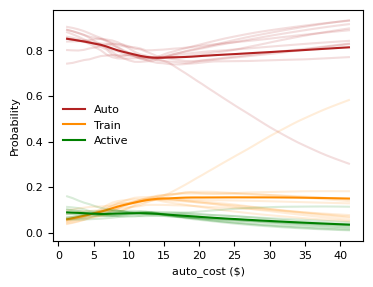

------------------------------ 
Model comparison:


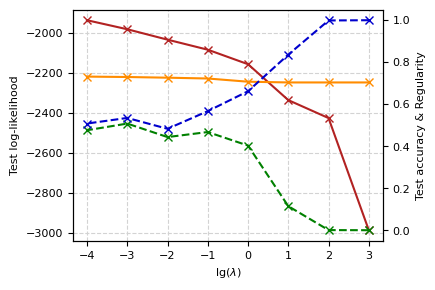

In [ ]:
# With norm
result('loss', [np.power(10, i) for i in np.arange(3, -5, -1.0)], False)